In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('dataset/battles_cleaned.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      38 non-null     object 
 1   year                      38 non-null     int64  
 2   battle_number             38 non-null     int64  
 3   attacker_king             36 non-null     object 
 4   defender_king             35 non-null     object 
 5   attacker_1                38 non-null     object 
 6   defender_1                37 non-null     object 
 7   attacker_outcome          38 non-null     object 
 8   battle_type               38 non-null     object 
 9   major_death               37 non-null     float64
 10  major_capture             37 non-null     float64
 11  attacker_size             24 non-null     float64
 12  defender_size             19 non-null     float64
 13  attacker_commander        37 non-null     object 
 14  defender_com

In [3]:
df.tail()

,name,year,battle_number,attacker_king,defender_king,attacker_1,defender_1,attacker_outcome,battle_type,major_death,...,defender_size,attacker_commander,defender_commander,summer,location,region,attacker_count,defender_count,attacker_commander_count,defender_commander_count
33,Second Seige of Storm's End,300,34,Joffrey/Tommen Baratheon,Stannis Baratheon,Baratheon,Baratheon,win,siege,0.0,...,200.0,"Mace Tyrell, Mathis Rowan",Gilbert Farring,0.0,Storm's End,The Stormlands,1,1,2,1
34,Siege of Dragonstone,300,35,Joffrey/Tommen Baratheon,Stannis Baratheon,Baratheon,Baratheon,win,siege,0.0,...,NaN,"Loras Tyrell, Raxter Redwyne",Rolland Storm,0.0,Dragonstone,The Stormlands,1,1,2,1
35,Siege of Riverrun,300,36,Joffrey/Tommen Baratheon,Robb Stark,Lannister,Tully,win,siege,0.0,...,NaN,"Daven Lannister, Ryman Fey, Jaime Lannister",Brynden Tully,0.0,Riverrun,The Riverlands,2,1,3,1
36,Siege of Raventree,300,37,Joffrey/Tommen Baratheon,Robb Stark,Bracken,Blackwood,win,siege,0.0,...,NaN,"Jonos Bracken, Jaime Lannister",Tytos Blackwood,0.0,Raventree,The Riverlands,2,1,2,1
37,Siege of Winterfell,300,38,Stannis Baratheon,Joffrey/Tommen Baratheon,Baratheon,Bolton,win,siege,NaN,...,8000.0,Stannis Baratheon,Roose Bolton,0.0,Winterfell,The North,4,2,1,1


### Impute Missing Values using IterativeImputer & SimpleImputer

[code reference](https://scikit-learn.org/stable/auto_examples/impute/plot_iterative_imputer_variants_comparison.html#imputing-missing-values-with-variants-of-iterativeimputer)

LabelEncoding untuk tipe data *object* dan drop kolom yang tidak digunakan

In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df[df.select_dtypes(['object']).columns] = df.select_dtypes(['object']).apply(lambda x: le.fit_transform(x.astype(str)))
df.drop(columns=['battle_number','attacker_commander','defender_commander'],inplace=True)

In [5]:
df.tail()

,name,year,attacker_king,defender_king,attacker_1,defender_1,attacker_outcome,battle_type,major_death,major_capture,attacker_size,defender_size,summer,location,region,attacker_count,defender_count,attacker_commander_count,defender_commander_count
33,29,300,1,4,0,0,1,3,0.0,0.0,NaN,200.0,0.0,22,5,1,1,2,1
34,31,300,1,4,0,0,1,3,0.0,0.0,2000.0,NaN,0.0,4,5,1,1,2,1
35,33,300,1,3,9,10,1,3,0.0,0.0,3000.0,NaN,0.0,15,4,2,1,3,1
36,32,300,1,3,2,1,1,3,0.0,1.0,1500.0,NaN,0.0,13,4,2,1,2,1
37,36,300,4,1,0,2,1,3,NaN,NaN,5000.0,8000.0,0.0,26,2,4,2,1,1


In [6]:
y = df['attacker_outcome']
X = df.drop(columns='attacker_outcome')

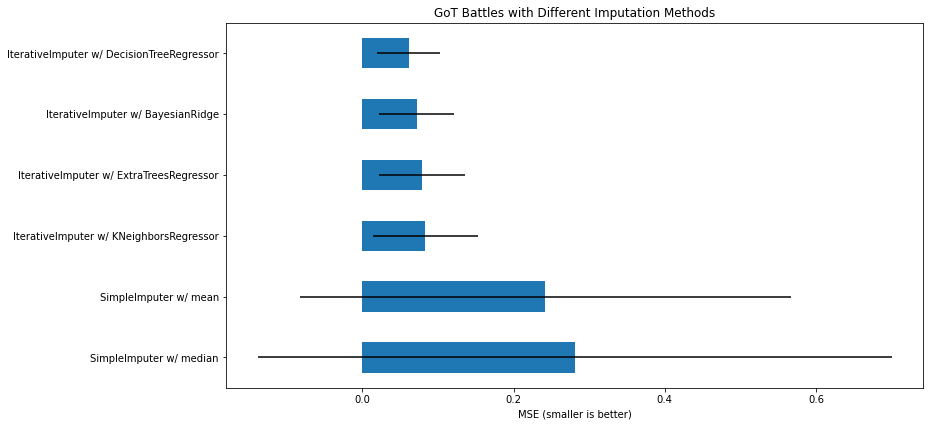

In [7]:
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler


N_SPLITS = 5
br_estimator = BayesianRidge()

np.random.seed(0)

# Estimate the score after imputation (mean and median strategies)
score_simple_imputer = pd.DataFrame()
for strategy in ('mean', 'median'):
    estimator = make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy=strategy),
        br_estimator
    )
    score_simple_imputer[strategy] = cross_val_score(
        estimator, X, y, scoring='neg_mean_squared_error',
        cv=N_SPLITS
    )
    
# Estimate the score after iterative imputation of the missing values
# with different estimators
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=0),
    ExtraTreesRegressor(n_estimators=10, random_state=0),
    KNeighborsRegressor(n_neighbors=6)
]

score_iterative_imputer = pd.DataFrame()
for impute_estimator in estimators:
    estimator = make_pipeline(
        StandardScaler(),
        IterativeImputer(random_state=0, estimator=impute_estimator),
        br_estimator
    )
    score_iterative_imputer[impute_estimator.__class__.__name__] = \
        cross_val_score(
            estimator, X, y, scoring='neg_mean_squared_error',
            cv=N_SPLITS
    )

scores = pd.concat(
    [score_simple_imputer, score_iterative_imputer],
    keys=['SimpleImputer', 'IterativeImputer'], axis=1
)

# plot california housing results
fig, ax = plt.subplots(figsize=(13, 6))
means = -scores.mean().sort_values()
errors = scores.std().sort_values()
means.plot.barh(xerr=errors, ax=ax)
ax.set_title('GoT Battles with Different Imputation Methods')
ax.set_xlabel('MSE (smaller is better)')
ax.set_yticks(np.arange(means.shape[0]))
ax.set_yticklabels([" w/ ".join(label) for label in means.index.tolist()])
plt.tight_layout(pad=1)
plt.show()

In [8]:
-scores.mean().sort_values(ascending=False)

IterativeImputer  DecisionTreeRegressor    0.061145
                  BayesianRidge            0.072023
                  ExtraTreesRegressor      0.078798
                  KNeighborsRegressor      0.082878
SimpleImputer     mean                     0.242051
                  median                   0.280627
dtype: float64